In [252]:
import numpy as np
import pandas as pd

from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import derivative
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']

dlib = DataLib('../SignalData')


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':'2010-01-01']
    return tbl


def predictive_accuracy(signal, objective, n=100):
    X = signal.long_form().dropna()
    X.date += pd.DateOffset(months=1)
    X = X.set_index(['date', 'country'])
    X = X.dropna()
    Y = objective.long_form().dropna().set_index(['date', 'country']).loc[X.index].dropna()
    X = X.loc[Y.index]
    confusion_matrix = None
    for _ in range(10):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        my_c_mat = pd.crosstab(Y_test['value'], Y_pred, rownames=['Actual'], colnames=['Predicted'])
        if confusion_matrix is not None:
            confusion_matrix += my_c_mat
        else:
            confusion_matrix = my_c_mat
    accuracy = (confusion_matrix.loc[-1, -1] + confusion_matrix.loc[1, 1]) / confusion_matrix.sum().sum()

    tbl = pd.concat([X, Y], axis=1)
    tbl.columns = ['x', 'y']
    print(tbl.query('y == 1')['x'].mean())
    print(tbl.query('y == -1')['x'].mean())
    tbl['y'] = tbl['y'].map(str)
    plot = (
        ggplot(tbl, aes(x='y', y='x')) +
            geom_jitter() +
            geom_boxplot()

    )
    return accuracy, confusion_matrix, plot

def plot_signal_against_objective(signal, objective):
    tbl1 = objective.long_form()
    tbl1['ticker'] = 'Objective'
    tbl2 = signal.long_form()
    tbl2['ticker'] = 'Signal'
    tbl1['value'] *= 1.2 * tbl2['value'].abs().max()
    tbl = pd.concat([tbl1, tbl2])

    return (
        ggplot(tbl, aes(x='date', y='value', color='ticker')) +
            geom_line() +
            geom_point() +
            scale_color_brewer(type='qualitative', palette=6) +
            ylab('value') +
            xlab('Date') +
            scale_x_date() +
            facet_grid('country~.') +
            theme(
                text=element_text(size=20),
                figure_size=(16, 12),
                legend_position='right',
                axis_text_x=element_text(size=20, angle=90, hjust=0),
                panel_border=element_rect(colour="black", size=2),
            )
    )


dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

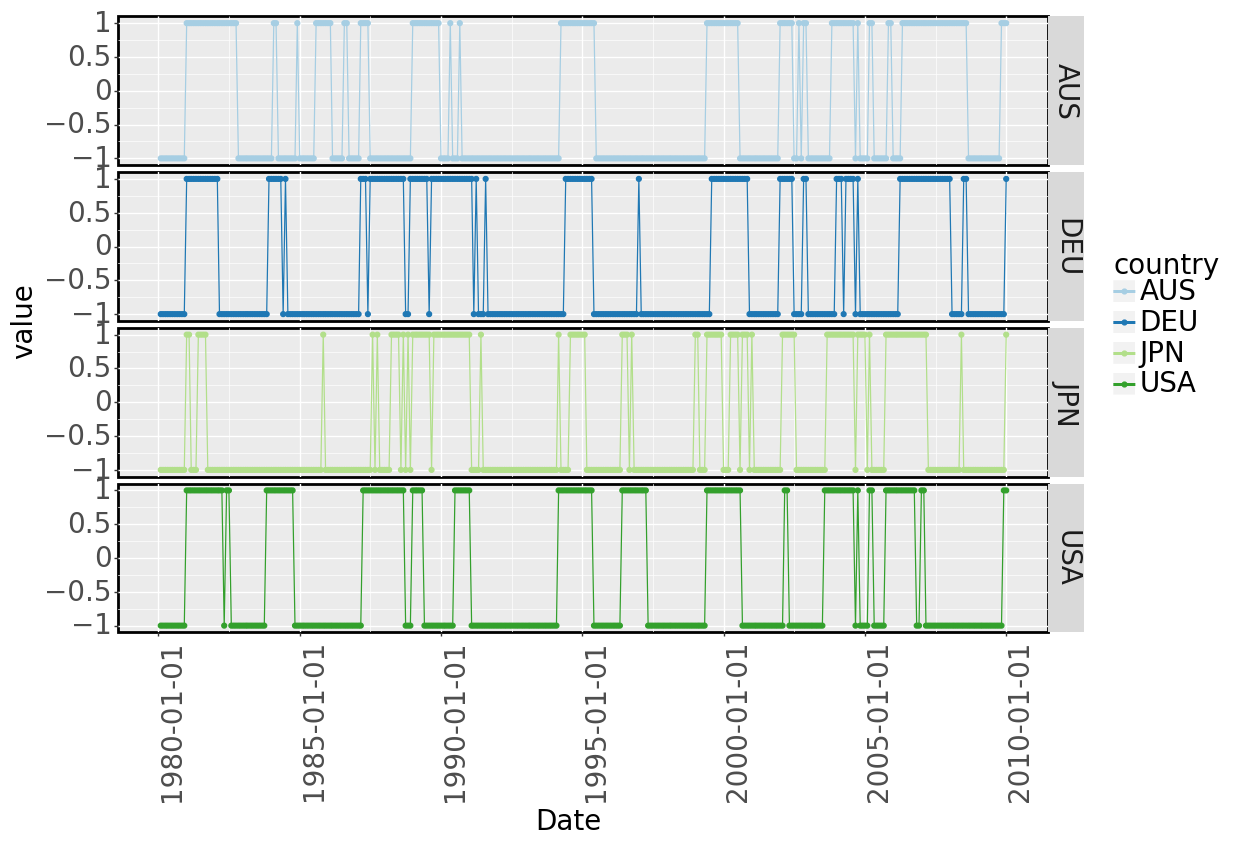

<ggplot: (8734454188187)>

In [253]:

lr_deriv = derivative(mask(dlib.pull('LongRates')))
lr_deriv = lr_deriv.rolling(12).mean()
lr_deriv = lr_deriv.applymap(lambda x: 1 if x > 0 else -1)
lr_deriv = Signal('LR Derivative', lr_deriv, normalizer=lambda x: x)

lr_deriv.plot() + facet_grid('country~.')

In [254]:
a = (lr_deriv.long_form()['value'] < 0).mean()
print(a)
a ** 2 + (1 - a) ** 2

0.6381944444444444


0.5381954089506172

# Monetary Base (M2)

/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()
/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:29: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 290 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


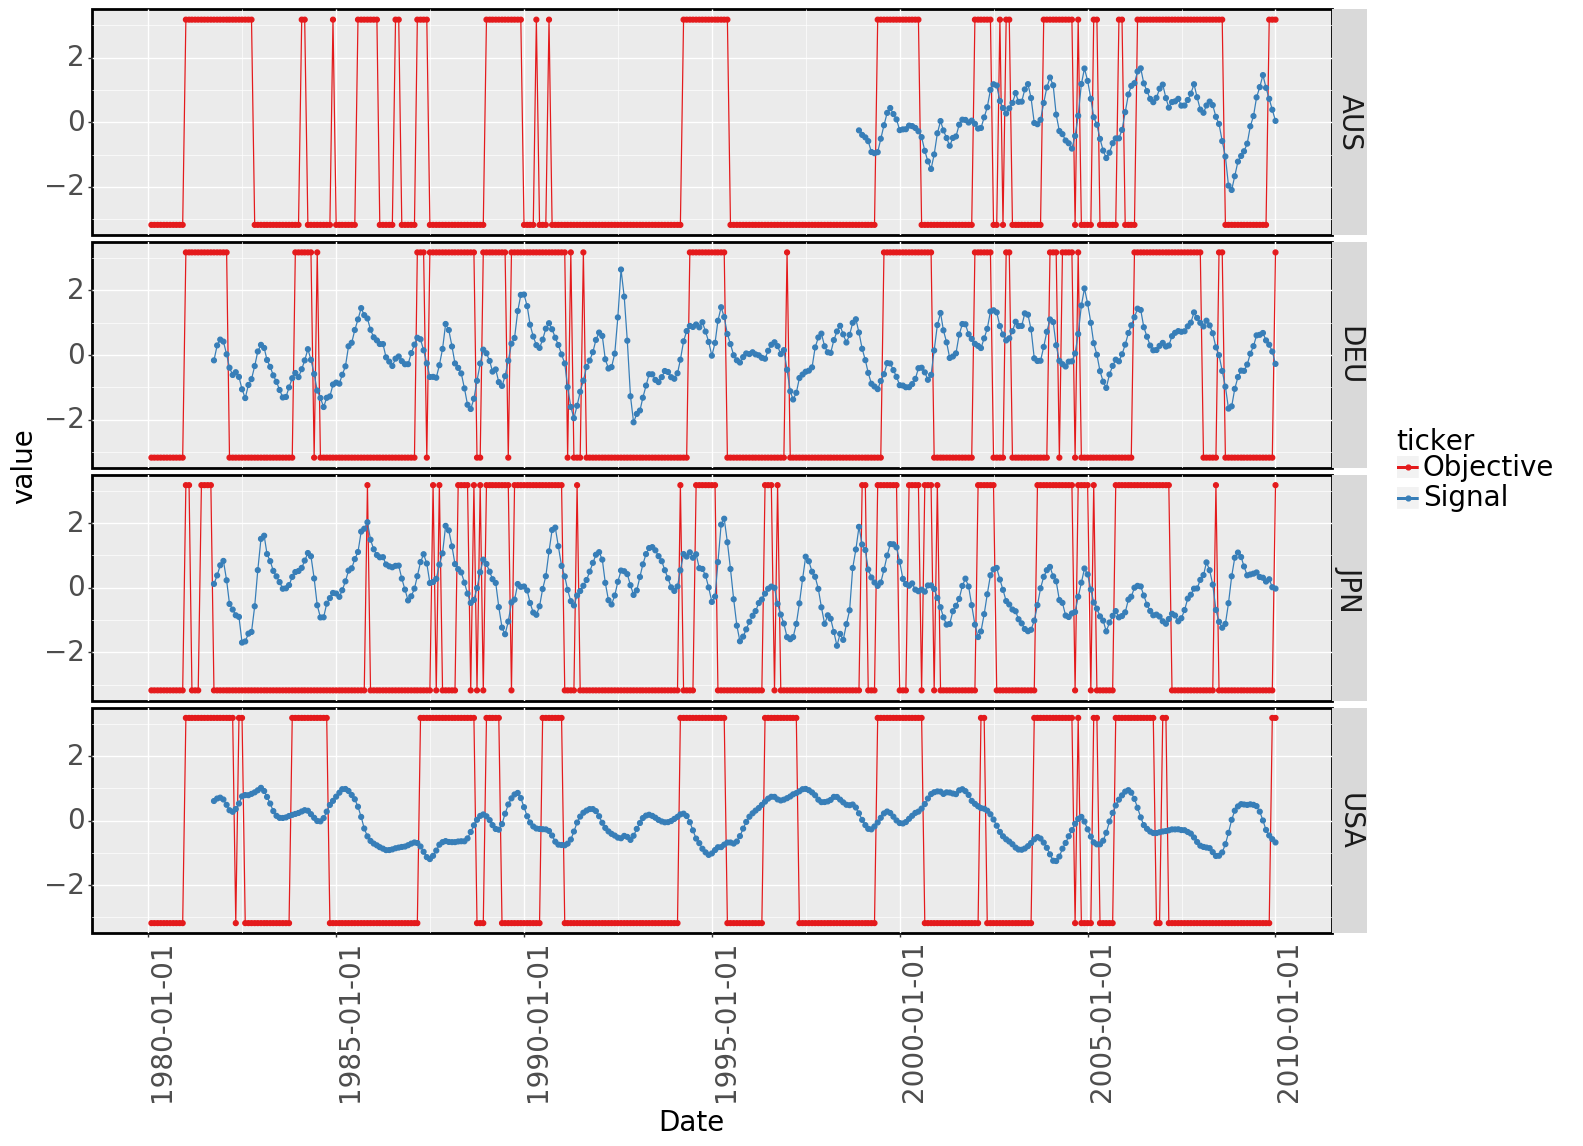

<ggplot: (-9223363302391699887)>

In [255]:

m2 = mask(dlib.pull('M2-inUSD'))
m2_3m = m2.rolling(3).mean()
m2_12m = m2.rolling(12).mean()
m2_delta = m2_3m / m2_12m
m2_delta = Signal('M2 Delta', m2_delta)
# m2_delta.data = m2_delta.data.applymap(lambda x: 1 if x > 0 else -1)
# m2_delta.tbl = m2_delta.data


plot_signal_against_objective(m2_delta, lr_deriv)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.06700595445792025
-0.004149535796492005


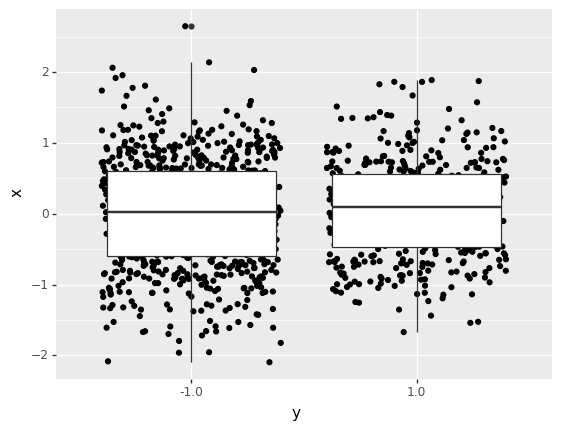

(0.528125, Predicted  -1.0   1.0
 Actual               
 -1.0       1125   676
  1.0        683   396, <ggplot: (-9223363302400749340)>)

In [256]:
predictive_accuracy(m2_delta, lr_deriv)

# CPI



/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 572 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


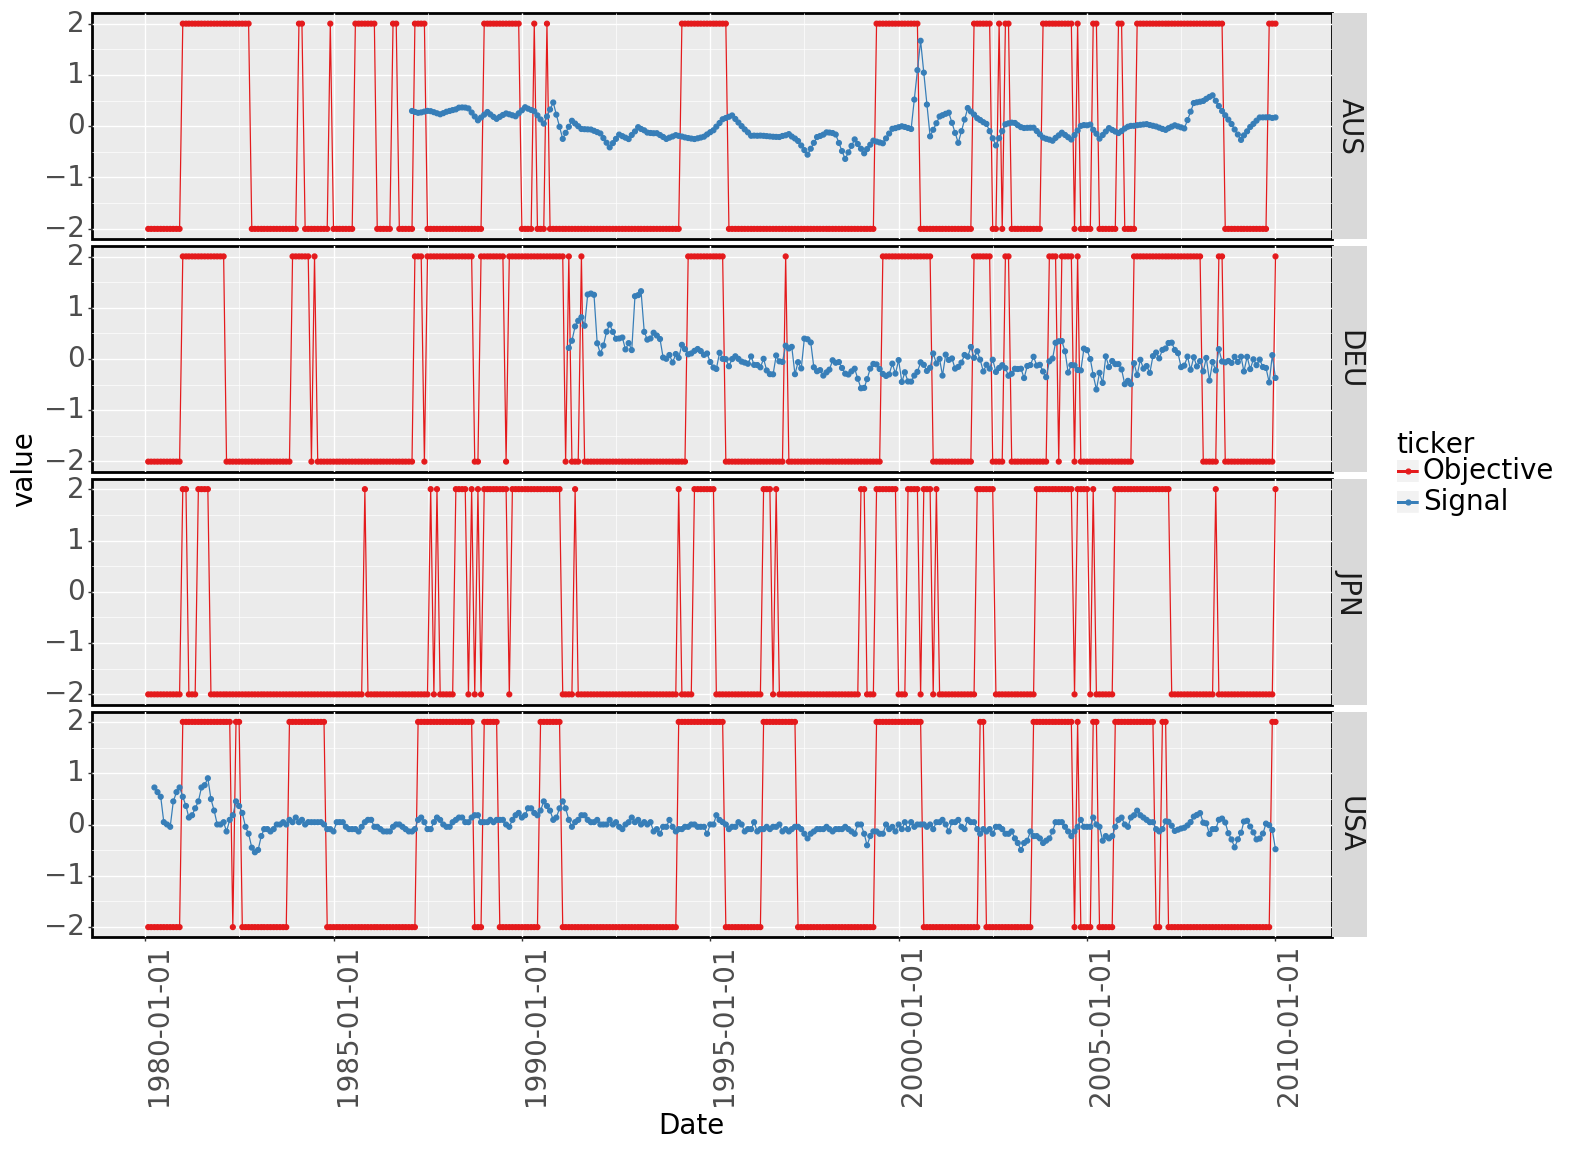

<ggplot: (8734463043697)>

In [257]:
cpi = mask(dlib.pull('CoreCPI-SA'))
cpi = derivative(cpi, s=3)
cpi = Signal('CPI', cpi, normalizer=lambda x: x - x.mean())

plot_signal_against_objective(cpi, lr_deriv)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.020512020236280883
-0.010325347097416525


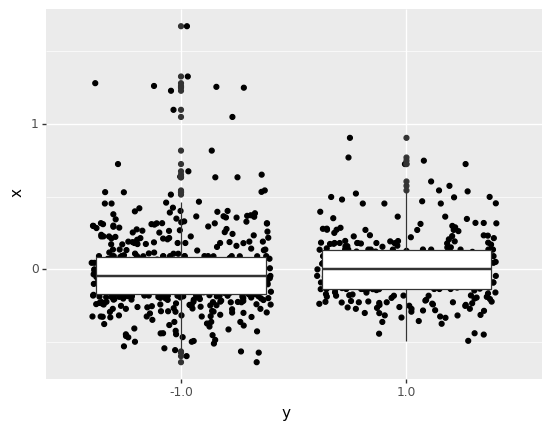

(0.5590697674418604, Predicted  -1.0   1.0
 Actual               
 -1.0        976   398
  1.0        550   226, <ggplot: (-9223363302400803026)>)

In [258]:
predictive_accuracy(cpi, lr_deriv)

# FX Appreciation

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 44 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


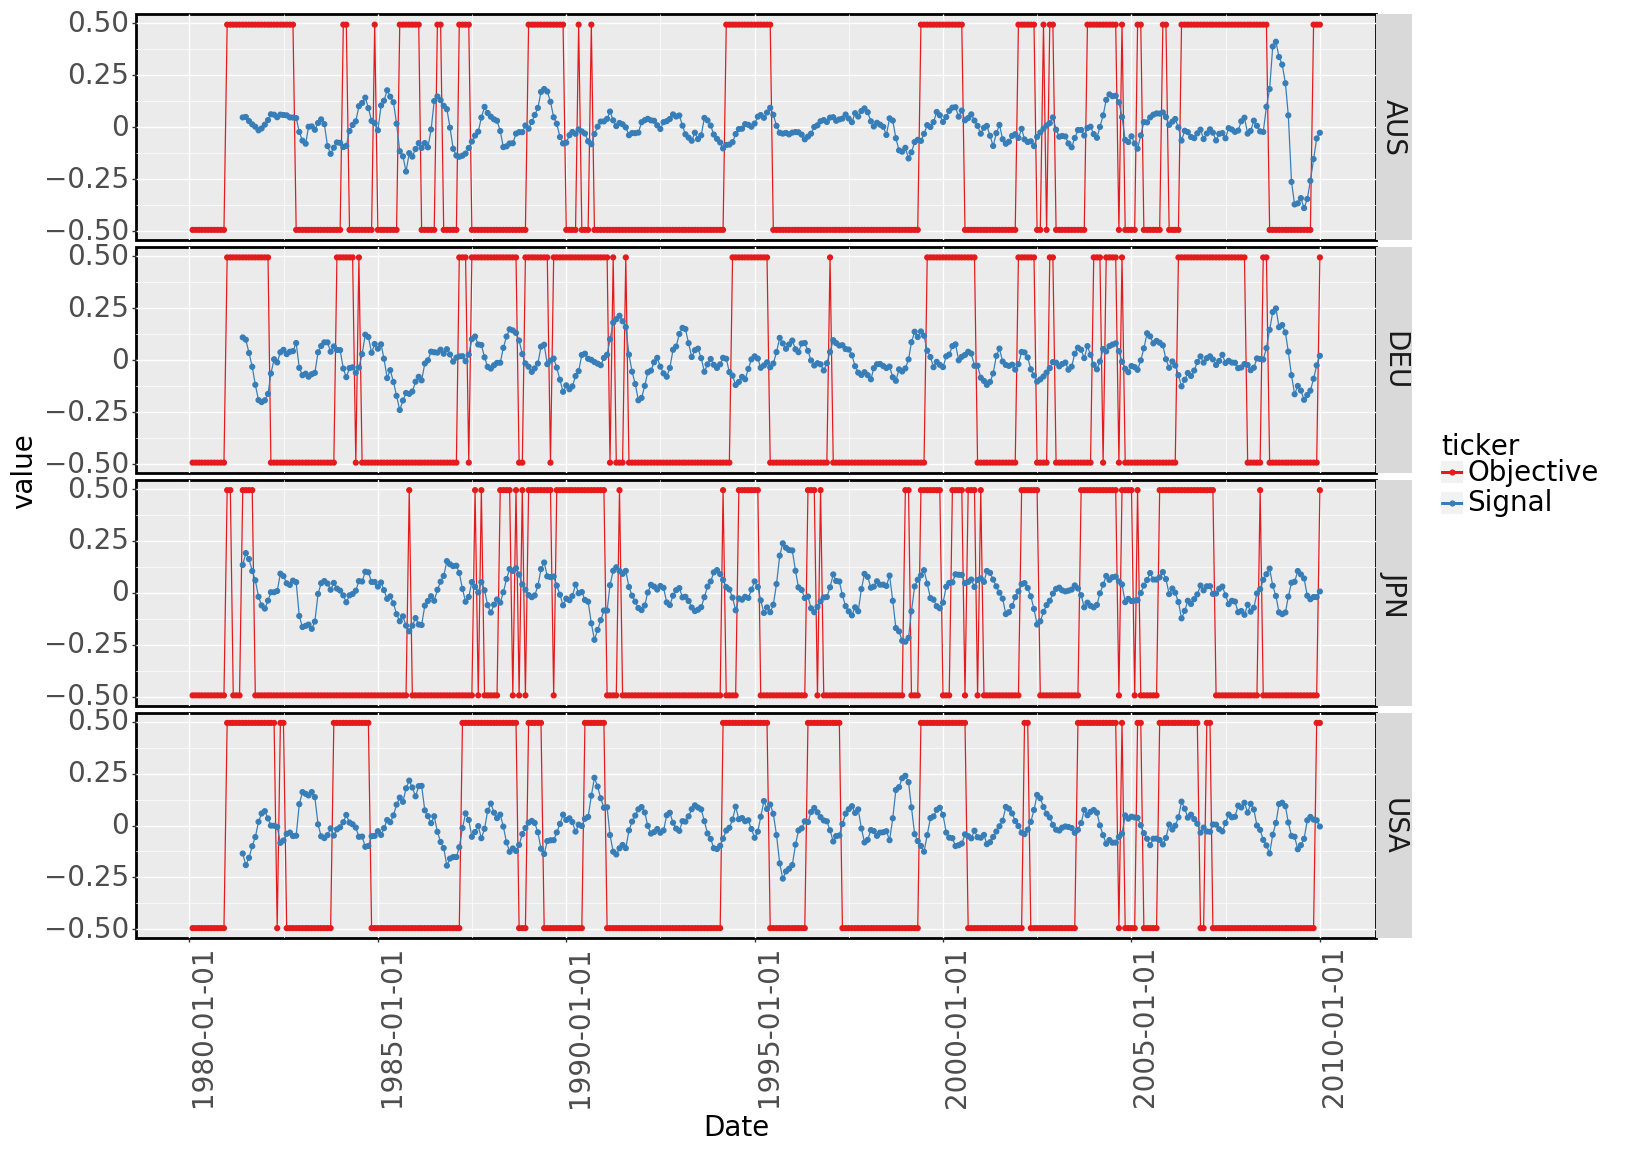

<ggplot: (-9223363302412286839)>

In [259]:
fx = mask(dlib.pull('fxVsUSD'))
fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
fx = fx.rolling(12).apply(lambda x: x[11] / x[:11].mean())
fx = derivative(fx, s=6)
fx = Signal('FX', fx, normalizer=lambda x: x)

plot_signal_against_objective(fx, lr_deriv)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

-0.0034006285720124636
-0.0004456677201622634


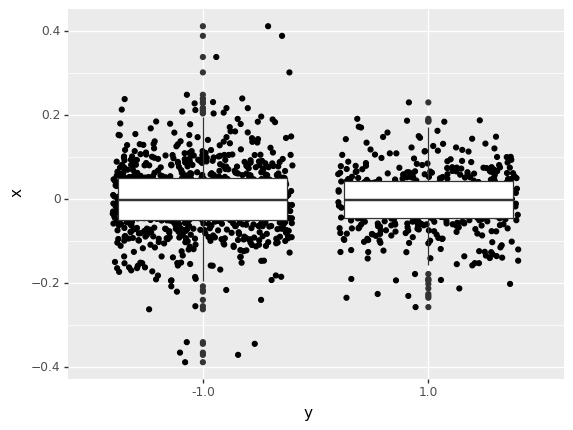

(0.5268221574344023, Predicted  -1.0   1.0
 Actual               
 -1.0       1372   815
  1.0        808   435, <ggplot: (-9223363302412341395)>)

In [260]:
predictive_accuracy(fx, lr_deriv)

# Combined

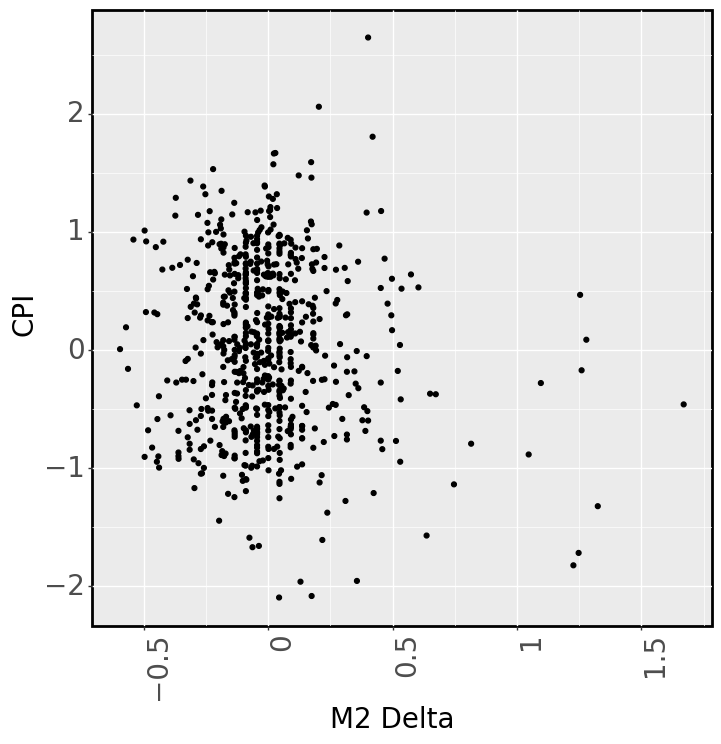

<ggplot: (-9223363302412356906)>

In [261]:
m2_delta.long_form()


def scatter(X, Y):
    x = X.long_form().dropna().set_index(['date', 'country'])
    y = Y.long_form().dropna().set_index(['date', 'country'])
    tbl = pd.concat([x, y], axis=1).dropna()
    tbl.columns = ['x', 'y']
    plot = (
        ggplot(tbl, aes(x='y', y='x')) +
            geom_point() +
            xlab(X.name) +
            ylab(Y.name) +
            theme(
                text=element_text(size=20),
                figure_size=(8, 8),
                legend_position='right',
                axis_text_x=element_text(size=20, angle=90, hjust=0),
                panel_border=element_rect(colour="black", size=2),
            )
    )
    return plot


scatter(m2_delta, cpi)
    

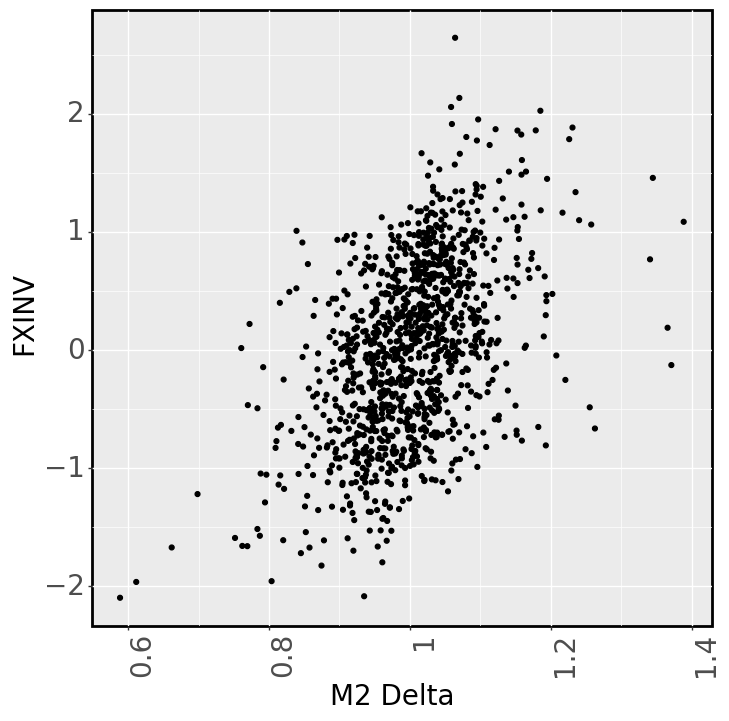

<ggplot: (-9223363302391737463)>

In [262]:

fxi = Signal('FXINV', 1 - fx.data, normalizer=lambda x: x)
scatter(m2_delta, fxi)

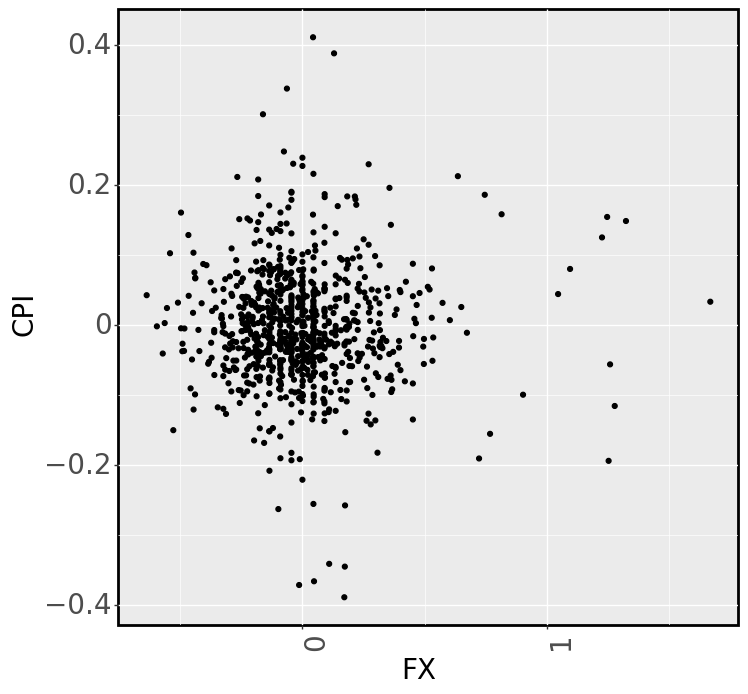

<ggplot: (8734454066738)>

In [263]:
scatter(fx, cpi)

In [264]:
comb = cpi.data + m2_delta.data - fx.data
comb = Indicator('combined', cpi, m2_delta, fxi)

def divergence_from_mean(tbl):
    row = tbl.iloc[-1]
    diff = (row - row.mean()).abs().sum()
    return diff

def divergence_from_median(tbl):
    row = tbl.iloc[-1]
    diff = (row - row.mean()).abs().sum()
    return diff

comb.metrics['div_from_mean'] = divergence_from_mean
comb.metrics['div_from_median'] = divergence_from_median

comb

In [265]:
comb.metrics

{'mean': <function globalbonds.indicators.combiners.Combiner.mean_value(tbl)>,
 'median': <function globalbonds.indicators.combiners.Combiner.median_value(tbl)>,
 'mean_first_deriv': <function globalbonds.indicators.combiners.Combiner.mean_first_derivative(tbl)>,
 'median_first_deriv': <function globalbonds.indicators.combiners.Combiner.median_first_derivative(tbl)>,
 'div_from_mean': <function __main__.divergence_from_mean(tbl)>,
 'div_from_median': <function __main__.divergence_from_median(tbl)>}

In [266]:
vals = comb.get_values_at_all_times(subsample=0.01)
vals

/home/dcdanko/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,metric,variable,value,date
0,mean,AUS,0.647835,1987-09-01
1,median,AUS,0.647835,1987-09-01
2,mean_first_deriv,AUS,NaN,1987-09-01
3,median_first_deriv,AUS,NaN,1987-09-01
4,div_from_mean,AUS,0.746496,1987-09-01
...,...,...,...,...
19,median,USA,0.092117,2008-07-01
20,mean_first_deriv,USA,1.032278,2008-07-01
21,median_first_deriv,USA,1.019992,2008-07-01
22,div_from_mean,USA,2.228592,2008-07-01


In [267]:
vals.set_index(['date', 'variable']).dropna()

metric     value
date       variable                              
1987-09-01 AUS                     mean  0.647835
           AUS                   median  0.647835
           AUS            div_from_mean  0.746496
           AUS          div_from_median  0.746496
           DEU                     mean  0.111934
...                                 ...       ...
2008-07-01 USA                   median  0.092117
           USA         mean_first_deriv  1.032278
           USA       median_first_deriv  1.019992
           USA            div_from_mean  2.228592
           USA          div_from_median  2.228592

[116 rows x 2 columns]

In [268]:


def i_predictive_accuracy(ind, objective, n=100, s=0.1):
    X = ind.get_values_at_all_times(subsample=s)
    X = X.dropna()
    X.date += pd.DateOffset(months=1)

    def wide_country(country):
        foo = X.query('variable == @country').pivot(index='date', columns='metric', values='value')
        foo['date'] = foo.index
        foo['country'] = country
        foo = foo.set_index(['date', 'country'])
        return foo
    
    X = pd.concat([wide_country(country) for country in X['variable'].unique()])
    
    X = X.dropna()
    Y = objective.long_form().dropna().set_index(['date', 'country']).loc[X.index].dropna()
    X = X.loc[Y.index]
    confusion_matrix = pd.DataFrame({-1: {-1: 0, 1: 0}, 1: {-1: 0, 1: 0}})
    for _ in range(10):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        my_c_mat = pd.crosstab(Y_test['value'], Y_pred, rownames=['Actual'], colnames=['Predicted'])
        confusion_matrix += my_c_mat
    accuracy = (confusion_matrix.loc[-1, -1] + confusion_matrix.loc[1, 1]) / confusion_matrix.sum().sum()

    return accuracy, confusion_matrix


x, y = i_predictive_accuracy(comb, lr_deriv, s=1)
x

/home/dcdanko/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

0.7614583333333333

In [249]:
y

,-1,1
-1,1906,359
1,660,675


In [269]:
mask(dlib.pull('BondRetIdx-LocalFX'))

country,USA,JPN,AUS,DEU
date,,,,
1980-01-01,37.527,NaN,NaN,49.321
1980-01-02,37.156,NaN,NaN,49.330
1980-01-03,36.941,NaN,NaN,49.163
1980-01-04,36.859,NaN,NaN,49.116
1980-01-07,36.926,NaN,NaN,49.125
...,...,...,...,...
2009-12-28,410.986,256.684,742.228,386.030
2009-12-29,412.536,256.808,732.617,385.773
2009-12-30,412.937,257.066,734.375,385.167


# Indicator Returns

In [279]:

def signalize(scores):
    scores = scores.T
    scores = scores - scores.mean()
    scores = scores / scores.abs().max()
    scores = scores.T
    return scores

def get_optimal_signal(dlib):
    optimal_signal = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    optimal_signal = (optimal_signal.pct_change() + 1)

    def minmaxsig(row):
        out = row.copy().fillna(0)
        out[:] = 0
        out[row.idxmax()] = 1
        out[row.idxmin()] = -1
        return out

    optimal_signal = optimal_signal.apply(minmaxsig, axis=1)
    optimal_signal = optimal_signal.drop(columns=optimal_signal.columns[4])
    return optimal_signal

def get_random_signal(dlib):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    random_signal = np.random.random(size=bond_returns.shape)
    random_signal = pd.DataFrame(random_signal, columns=bond_returns.columns, index=bond_returns.index)
    random_signal = signalize(random_signal)
    return random_signal

def calc_signal_returns(dlib, signal):
    signal = signal.copy().fillna(0)
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = (signal_returns.sum(axis=1) + 1)
    signal_returns = signal_returns.cumprod()
    return signal_returns


    
random_signal = get_random_signal(dlib)
random_returns = calc_signal_returns(dlib, random_signal)

optimal_signal = get_optimal_signal(dlib)
optimal_returns = calc_signal_returns(dlib, optimal_signal)
optimal_returns

date
1980Q1     1.000000
1980Q2     1.097805
1980Q3     1.174658
1980Q4     1.196120
1981Q1     1.249475
            ...    
2009Q1    68.559659
2009Q2    71.165251
2009Q3    73.712668
2009Q4    74.253336
2010Q1    76.660543
Freq: Q-DEC, Length: 121, dtype: float64

In [274]:
m2_sig = m2_delta.data.resample('Q').mean()
m2_sig = signalize(m2_sig)

m2_returns = calc_signal_returns(dlib, m2_sig)
m2_returns

date
1980Q1    1.000000
1980Q2    1.000000
1980Q3    1.000000
1980Q4    1.000000
1981Q1    1.000000
            ...   
2009Q1    1.125972
2009Q2    1.142015
2009Q3    1.121127
2009Q4    1.123002
2010Q1    1.151401
Freq: Q-DEC, Length: 121, dtype: float64

In [275]:
cpi_sig = cpi.data.resample('Q').mean()
cpi_sig = signalize(cpi_sig)

cpi_returns = calc_signal_returns(dlib, cpi_sig)
cpi_returns

date
1980Q1    1.000000
1980Q2    1.000000
1980Q3    1.000000
1980Q4    1.000000
1981Q1    1.000000
            ...   
2009Q1    1.120364
2009Q2    1.083000
2009Q3    1.067352
2009Q4    1.064373
2010Q1    1.076837
Freq: Q-DEC, Length: 121, dtype: float64

In [277]:
fx_sig = fx.data.resample('Q').mean()
fx_sig = signalize(fx_sig)

fx_returns = calc_signal_returns(dlib, fx_sig)
fx_returns

date
1980Q1    1.000000
1980Q2    1.000000
1980Q3    1.000000
1980Q4    1.000000
1981Q1    1.000000
            ...   
2009Q1    1.317327
2009Q2    1.360075
2009Q3    1.394347
2009Q4    1.389681
2010Q1    1.401114
Freq: Q-DEC, Length: 121, dtype: float64

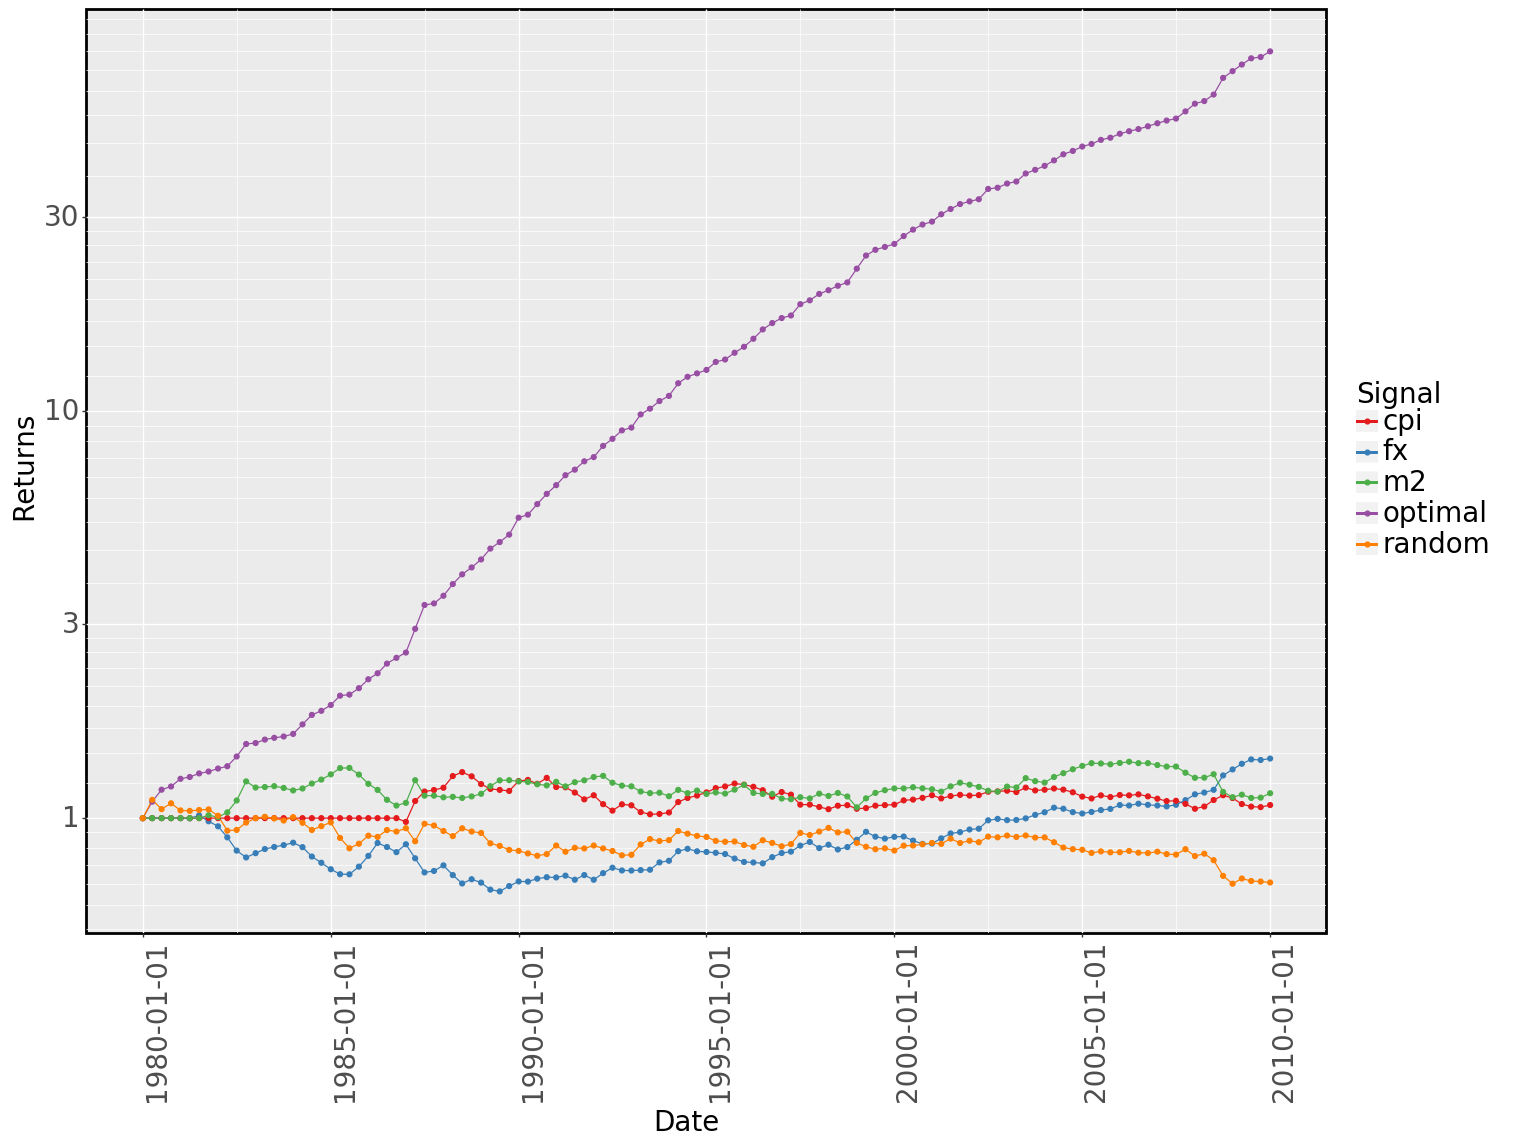

<ggplot: (8734445078564)>

In [280]:
df = pd.DataFrame({
    'fx': fx_returns,
    'optimal': optimal_returns,
    'cpi': cpi_returns,
    'm2': m2_returns,
    'random': random_returns,
})
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')

(
    ggplot(df, aes(x='date', y='value', color='variable')) +
        geom_line() +
        geom_point() +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)